In [2]:
from collections import defaultdict as ddict
from typing import Dict, Tuple
from itertools import combinations

import sqlite3
import pandas as pd
from matplotlib.colors import hsv_to_rgb
import statsmodels.api as sm
import seaborn as sns
import freeman as fm
from math import log
import networkx as nx

In [3]:
con = sqlite3.connect("./Formula1.sqlite")
cursor = con.cursor()

In [4]:
data = cursor.execute("""
SELECT RES.raceid, D.driverRef, RES.driverId, RACES.date -- , RES.position
FROM results RES
JOIN drivers D ON D.driverId = RES.driverId
JOIN races RACES ON RACES.raceId = RES.raceId
WHERE RES.position > 0 AND RES.position <= 3
""").fetchall()

In [5]:
df = pd.DataFrame(data, columns=["race_id", "driver_ref", "driver_id", "date"])
df.loc[:, "date"] = df["date"].apply(pd.to_datetime)
df.head()

,race_id,driver_ref,driver_id,date
0,18,hamilton,1,2008-03-16
1,18,heidfeld,2,2008-03-16
2,18,rosberg,3,2008-03-16
3,19,raikkonen,8,2008-03-23
4,19,kubica,9,2008-03-23


In [6]:
# num_races: Dict[int, int] = dict(cursor.execute("""
# SELECT driverId, count(*)
# FROM results
# WHERE position > 0 AND position <= 3
# GROUP BY driverId
# """).fetchall())

In [7]:
d = ddict(int)
nodes: Dict[int, str] = {}
network: Dict[Tuple[int, int], int] = ddict(int)
podiums: Dict[int, int] = ddict(int)


def f(gb: pd.Series):
    def assign_nodes(s: pd.Series):
        nodes[s["driver_id"]] = s["driver_ref"]
    gb.apply(assign_nodes, axis=1)
    ids = gb.sort_values(by=["driver_id"])["driver_id"].values
    
    for id_ in set(ids):
        podiums[id_] += 1
    
    for c in combinations(ids, 2):
        if c[0] != c[1]:
            network[c] += 1

    
    
df.groupby('race_id').apply(f)

""


In [8]:
career_time: Dict[int, int] = {}
for driver_id in nodes:
    dates = df[df["driver_id"] == driver_id]["date"]
    career_time[driver_id] = (dates.max() - dates.min()).days

In [9]:
# network

In [10]:
    with open("/tmp/out.gml", "w+") as f:
        
        node_str = ""
        for node in nodes:
            node_str += f'    node [\n        id {node}\n        name "{nodes[node]}"\n'
            node_str += f'        time {career_time[node]}    ]\n'
        
        edge_str = ""
        for ((id0, id1), weight) in network.items():
            edge_str += f"    edge [\n        source {id0}\n"
            edge_str += f"        target {id1}\n        weight {weight}\n    ]\n"
        
        f.write("graph [\n    directed 0\n")
        f.write(node_str)
        f.write(edge_str)
        f.write("]\n")        

In [11]:
g = fm.load("/tmp/out.gml")

In [12]:
g.set_all_nodes("size", 5)
g.set_all_nodes("labpos", "hover")
g.set_all_edges("color", (127, 127, 127))
g.label_nodes("name")

g.move("kamada_kawai")
g.draw()

In [13]:
bc = nx.betweenness_centrality(g)

In [14]:
helionp = pd.concat([
    pd.Series(bc, name="betweenness"),
    pd.Series(career_time, name="career_time"),
    pd.Series(podiums, name="podiums"),
],axis = 1)

b0 = helionp[helionp["betweenness"] == 0]

bnot0 = helionp[helionp["betweenness"] != 0].copy()
bnot0["betweenness"] = bnot0["betweenness"].apply(log)
b_min, b_max = bnot0["betweenness"].min(), bnot0["betweenness"].max()
bnot0["betweenness"] = bnot0["betweenness"].apply(lambda b: (b - b_min) / (b_max - b_min))

# c_min, c_max = bnot0["career_time"].min(), bnot0["career_time"].max()
# bnot0["career_time"] = bnot0["career_time"].apply(lambda c: (c - c_min) / (c_max - c_min))

x = bnot0[["betweenness", "podiums"]]
y = bnot0["career_time"]
model = sm.OLS(y, x)
result = model.fit()
print(result.pvalues)
result.summary()


betweenness    4.641832e-26
podiums        5.143934e-15
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            career_time   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              543.9
Date:                Tue, 22 Jun 2021   Prob (F-statistic):                    1.37e-60
Time:                        00:46:39   Log-Likelihood:                         -984.42
No. Observations:                 121   AIC:                                      1973.
Df Residuals:                     119   BIC:                                      1978.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
betweenness  2487.0323    182.468     13.630      0.000    2125.727    2848.337
podiums        29.9006      3.334      8.969      0.000      23.299      36.502
==============================================================================
Omnibus:                        7.504   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.729
Skew:                           0.619   Prob(JB):                       0.0210
Kurtosis:                       2.950   Cond. No.                         84.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

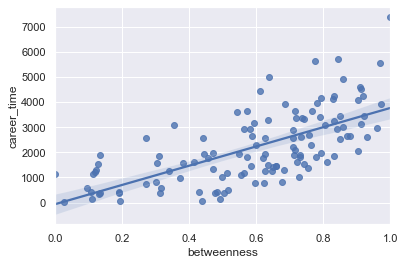

In [15]:
sns.regplot(x="betweenness", y="career_time", data=bnot0);

In [16]:
b_max = helionp["betweenness"].max()
bet = helionp["betweenness"].apply(lambda x: x / b_max)

In [17]:
g.set_all_nodes("size", 10)
g.set_all_nodes("labpos", "hover")
g.set_all_edges("color", (127, 127, 127))
g.label_nodes("name")


for item in bet.iteritems():
    idx, b = item
    g.nodes[idx]["color"] = tuple([int(i) for i in hsv_to_rgb((0, b, 1)) * 255])

g.move("kamada_kawai")
g.draw()